## Lưu Trữ Dữ Liêu

Cài đặt HADOOP và Spark

In [ ]:
# Cài đặt JDK 8 tương thích với Hadoop
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Tải và giải nén Hadoop
!wget -q https://downloads.apache.org/hadoop/common/hadoop-3.3.5/hadoop-3.3.5.tar.gz
!tar -xf hadoop-3.3.5.tar.gz
!cp -r hadoop-3.3.5 /usr/lo
cal/

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
JAVA_HOME = !readlink -f /usr/bin/java | sed "s:bin/java::"
java_home_text = JAVA_HOME[0]
java_home_text_command = f"$ {JAVA_HOME[0]} "
!echo export JAVA_HOME=$java_home_text >>/usr/local/hadoop-3.3.5/etc/hadoop/hadoop-env.sh

In [ ]:
import os
# Thiết lập biến môi trường JAVA_HOME và HADOOP_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["HADOOP_HOME"] = "/usr/local/hadoop-3.3.5"

In [ ]:
!/usr/local/hadoop-3.3.5/bin/hadoop fs -mkdir Project

In [ ]:
!/usr/local/hadoop-3.3.5/bin/hadoop fs -mkdir Project/Data
!/usr/local/hadoop-3.3.5/bin/hadoop fs -copyFromLocal /content/dataset.csv Project/Data

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar -xf spark-3.2.1-bin-hadoop3.2.tgz

#findspark giúp tìm kiếm Spark và thiết lập môi trường và py4j cho phép kết nối Java với Python
!pip install -q findspark py4j pyspark

In [ ]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

# Tạo Spark session với cấu hình đầy đủ
spark = SparkSession.builder \
    .master("local") \
    .appName("Preprocessing") \
    .config("spark.ui.port", "4050") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Kiểm tra file tồn tại
import os
assert os.path.exists("/content/dataset.csv"), "Không tìm thấy file dataset.csv"

print(" Hadoop và Spark đã sẵn sàng.")


 Hadoop và Spark đã sẵn sàng.


## Tiền Xử Lý

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
    StructField("Location", StringType(), True),
    StructField("Company", StringType(), True),
    StructField("Title", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Requirements", StringType(), True),
    StructField("Salary", StringType(), True),
    StructField("Benefits", StringType(), True),
    StructField("Link", StringType(), True)
])

df = spark.read.format("csv") \
    .option("header", True) \
    .option("multiline", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("mode", "PERMISSIVE") \
    .schema(schema) \
    .load("/content/dataset.csv")

df.printSchema()
df.show(5, truncate=False)


root
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Requirements: string (nullable = true)
 |-- Salary: string (nullable = true)
 |-- Benefits: string (nullable = true)
 |-- Link: string (nullable = true)

+--------+---------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df.cache()
df_preprocessed = df.alias("df_preprocessed")
df_preprocessed.printSchema()

root
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Requirements: string (nullable = true)
 |-- Salary: string (nullable = true)
 |-- Benefits: string (nullable = true)
 |-- Link: string (nullable = true)



In [ ]:
# Thực hiện chuẩn hóa schema

# Xem tên cột hiện tại để kiểm tra
print("Tên cột gốc:")
print(df_preprocessed.columns)

# Tạo mapping đổi tên schema (viết thường, snake_case)
column_mapping = {
    'Location': 'location',
    'Company': 'company',
    'Title': 'title',
    'Description': 'description',
    'Requirements': 'requirements',
    'Salary': 'salary',
    'Benefits': 'benefits',
    'Link': 'link'
}

# Thực hiện chuẩn hóa tên cột theo mapping trên
for old_col, new_col in column_mapping.items():
    if old_col in df_preprocessed.columns:
        df_preprocessed = df_preprocessed.withColumnRenamed(old_col, new_col)

# Kiểm tra lại schema sau khi chuẩn hóa
print("Schema sau khi chuẩn hóa:")
df_preprocessed.printSchema()

# Hiển thị lại 5 dòng đầu tiên sau chuẩn hóa tên cột để xác nhận
df_preprocessed.show(5, truncate=False)


Tên cột gốc:
['Location', 'Company', 'Title', 'Description', 'Requirements', 'Salary', 'Benefits', 'Link']
Schema sau khi chuẩn hóa:
root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- link: string (nullable = true)

+--------+---------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import col, count, when, isnan, approx_count_distinct

print(" 1️. Tổng số dòng và số lượng cột ")
print(f"Số dòng: {df_preprocessed.count()}, Số cột: {len(df_preprocessed.columns)}")
print("\nDanh sách cột:", df_preprocessed.columns)

print("\n2. Schema chi tiết")
df_preprocessed.printSchema()

print("\n3. Thống kê null từng cột")
null_ratio_df = df_preprocessed.select([
    (count(when(col(c).isNull() | isnan(c) | (col(c) == ''), c)) / count("*")).alias(c)
    for c in df_preprocessed.columns
])
null_ratio_df.show(truncate=False)

print("\n 4. Thống kê số lượng giá trị duy nhất (approx) của từng cột")
unique_count_df = df_preprocessed.select([
    approx_count_distinct(col(c)).alias(c)
    for c in df_preprocessed.columns
])
unique_count_df.show(truncate=False)

print("\n5. Kiểm tra trùng lặp toàn bộ dòng")
duplicate_count = df_preprocessed.count() - df_preprocessed.dropDuplicates().count()
print(f"Số lượng dòng trùng lặp hoàn toàn: {duplicate_count}")

print("\n6. Xem nhanh 10 dòng đầu tiên để quan sát dữ liệu")
df_preprocessed.show(10, truncate=False)


 1️. Tổng số dòng và số lượng cột 
Số dòng: 2715, Số cột: 8

Danh sách cột: ['location', 'company', 'title', 'description', 'requirements', 'salary', 'benefits', 'link']

2. Schema chi tiết
root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- link: string (nullable = true)


3. Thống kê null từng cột
+--------+-------+-----+---------------------+---------------------+------+--------------------+----+
|location|company|title|description          |requirements         |salary|benefits            |link|
+--------+-------+-----+---------------------+---------------------+------+--------------------+----+
|0.0     |0.0    |0.0  |0.0066298342541436465|0.0066298342541436465|0.0   |0.012154696132596685|0.0 |
+--------+-------+-----+---------------------+------

In [ ]:
#xóa bỏ cột dư thừa
df_preprocessed = df_preprocessed.drop('link')
# Kiểm tra lại schema sau khi chuẩn hóa
print("Schema sau khi xóa:")
df_preprocessed.printSchema()

Schema sau khi xóa:
root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)



In [ ]:
import pyspark.sql.functions as F

# Áp dụng làm sạch cho các cột văn bản chính
text_columns = ['title', 'company','description', 'requirements', 'benefits','location' ]

for col_name in text_columns:
    if col_name in df_preprocessed.columns:
        # Loại bỏ HTML tags
        cleaned_col = F.regexp_replace(df_preprocessed[col_name], '<[^>]*>', ' ')
        # Thay newline và return thành dấu phẩy
        cleaned_col = F.regexp_replace(cleaned_col, '[\\n\\r]+', ', ')
        # Loại bỏ ký tự không phải chữ/số/khoảng trắng/dấu câu cơ bản (Unicode support)
        cleaned_col = F.regexp_replace(cleaned_col, '[^\\p{L}\\p{N}\\s\\.,;:()/\\-]', ' ')
        # Chuẩn hóa khoảng trắng
        cleaned_col = F.regexp_replace(cleaned_col, '\\s+', ' ')
        # Loại khoảng trắng đầu/cuối
        cleaned_col = F.trim(cleaned_col)
        cleaned_col = F.lower(cleaned_col)

        # Tạo cột mới _cleaned
        df_preprocessed = df_preprocessed.withColumn(f"{col_name}_cleaned", cleaned_col)

# Kiểm tra lại schema sau khi tạo cột _cleaned
print("Schema sau khi tạo các cột cleaned:")
df_preprocessed.printSchema()

# Hiển thị lại 5 dòng đầu tiên cho cột  kiểm tra
df_preprocessed.select("title_cleaned", "description_cleaned","requirements_cleaned", "benefits_cleaned").show(5, truncate=False)


Schema sau khi tạo các cột cleaned:
root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- title_cleaned: string (nullable = true)
 |-- company_cleaned: string (nullable = true)
 |-- description_cleaned: string (nullable = true)
 |-- requirements_cleaned: string (nullable = true)
 |-- benefits_cleaned: string (nullable = true)
 |-- location_cleaned: string (nullable = true)

+----------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
text_cols_to_update = ['title_cleaned', 'description_cleaned', 'requirements_cleaned', 'benefits_cleaned']

# Mapping địa danh phổ biến
location_mapping = {
    'ha noi': 'hà nội',
    'ho chi minh': 'hồ chí minh',
    'tphcm': 'hồ chí minh',
    'tp hcm': 'hồ chí minh',
    'hcm': 'hồ chí minh',
    'da nang': 'đà nẵng',
    'can tho': 'cần thơ',
    'hai phong': 'hải phòng',
    'binh duong': 'bình dương',
}

for col_name in text_cols_to_update:
    if col_name in df_preprocessed.columns:
        for k, v in location_mapping.items():
            # Dùng regexp_replace để thay thế từng biến thể thành chuẩn
            df_preprocessed = df_preprocessed.withColumn(
                col_name,
                F.regexp_replace(F.col(col_name), fr'\b{k}\b', v)
            )
df_preprocessed.select("location_cleaned","title_cleaned", "description_cleaned").show(10, truncate=False)


+----------------+----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# xử lý dữ liệu lương
from pyspark.sql import functions as F

# Loại HTML + lowercase + trim
df_preprocessed = df_preprocessed.withColumn(
    "salary_cleaned",
    F.trim(
        F.regexp_replace(
            F.lower(F.col("salary")),
            r'<[^>]+>',
            ' '
        )
    )
)

# Chuẩn hóa khoảng trắng
df_preprocessed = df_preprocessed.withColumn(
    "salary_cleaned",
    F.regexp_replace(F.col("salary_cleaned"), r'\s+', ' ')
)

# DÙNG \p{L}\p{N} giữ lại số + chữ + dấu cơ bản
df_preprocessed = df_preprocessed.withColumn(
    "salary_cleaned",
    F.regexp_replace(
        F.col("salary_cleaned"),
        r"[^\p{L}\p{N}\s.,–\-+]",  # Giữ lại: chữ cái Unicode, số Unicode, khoảng trắng, dấu .,–-+
        ''
    )
)

# Fill 'unknown'
df_preprocessed = df_preprocessed.withColumn(
    "salary_cleaned",
    F.when(
        (F.col("salary_cleaned").isNull()) | (F.col("salary_cleaned") == ''),
        "unknown"
    ).otherwise(F.col("salary_cleaned"))
)
df_preprocessed.select("salary_cleaned").show(10, truncate=False)


+-----------------+
|salary_cleaned   |
+-----------------+
|12.5 - 14.5 triệu|
|10 - 30 triệu    |
|thoả thuận       |
|10 - 40 triệu    |
|thoả thuận       |
|10 - 15 triệu    |
|tới 180 triệu    |
|8 - 12 triệu     |
|10 - 50 triệu    |
|tới 100 triệu    |
+-----------------+
only showing top 10 rows



In [ ]:
# dClean một số noise như chữ cái đứng một mình trong bài
from pyspark.sql import functions as F

cols_to_fix_ocr = [
    'title_cleaned',
    'description_cleaned',
    'requirements_cleaned',
    'benefits_cleaned',
    'salary_cleaned'
]

for col_name in cols_to_fix_ocr:
    # Xoá chữ đơn lẻ kèm dấu chấm hoặc phẩy (ví dụ: "s . mức lương" ➔ "mức lương")
    df_preprocessed = df_preprocessed.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), r'\b([eas])\s*[\.,]', '')
    )

    # Xoá chữ đơn lẻ rải rác (ví dụ: " tìm e mức lương" ➔ "tìm mức lương")
    df_preprocessed = df_preprocessed.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), r'\b([eas])\b', '')
    )

    # Chuẩn hóa khoảng trắng giữa cââu
    df_preprocessed = df_preprocessed.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), r'\s+', ' ')
    )

    # Xoá dấu chấm / dấu phẩy đầu hoặc cuối câu (nếu cần)
    df_preprocessed = df_preprocessed.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), r'^[\.,]\s*|\s*[\.,]$', '')
    )
    #Trim sạch đầu/cuối chuỗi
    df_preprocessed = df_preprocessed.withColumn(
            col_name,
            F.trim(F.col(col_name))
    )
# Kiểm tra nhanh
df_preprocessed.select(*cols_to_fix_ocr).show(10, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Fill missing
text_cols_to_fill = ['title_cleaned', 'description_cleaned', 'requirements_cleaned', 'benefits_cleaned', 'location_cleaned', 'company_cleaned']

for col_name in text_cols_to_fill:
    df_preprocessed = df_preprocessed.withColumn(
        col_name,
        F.when(F.col(col_name).isNull(), 'unknown').otherwise(F.col(col_name))
    )
print("Thống kê null từng cột")
null_ratio_df = df_preprocessed.select([
    (count(when(col(c).isNull() | isnan(c) | (col(c) == ''), c)) / count("*")).alias(c)
    for c in df_preprocessed.columns
])
null_ratio_df.show(truncate=False)

Thống kê null từng cột
+--------+-------+-----+---------------------+---------------------+------+--------------------+-------------+---------------+-------------------+--------------------+----------------+----------------+--------------+
|location|company|title|description          |requirements         |salary|benefits            |title_cleaned|company_cleaned|description_cleaned|requirements_cleaned|benefits_cleaned|location_cleaned|salary_cleaned|
+--------+-------+-----+---------------------+---------------------+------+--------------------+-------------+---------------+-------------------+--------------------+----------------+----------------+--------------+
|0.0     |0.0    |0.0  |0.0066298342541436465|0.0066298342541436465|0.0   |0.012154696132596685|0.0          |0.0            |0.0                |0.0                 |0.0             |0.0             |0.0           |
+--------+-------+-----+---------------------+---------------------+------+--------------------+-------------

In [ ]:
import pandas as pd

# Lấy schema (các cột) từ DataFrame để chọn dữ liệu
columns = ["location_cleaned", "company_cleaned", "title_cleaned",
           "description_cleaned", "requirements_cleaned",
           "benefits_cleaned", "salary_cleaned"]

# Collect dữ liệu từ PySpark thành list
data_rows = df_preprocessed.select(*columns).collect()

# Convert sang Pandas DataFrame với unique_id
final_df = pd.DataFrame([row.asDict() for row in data_rows])  # Sửa ở đây: dùng pd.DataFrame thay vì df_preprocessed.DataFrame
final_df.insert(0, "unique_id", range(1, len(final_df) + 1))  # Thêm cột unique_id

# Export file
final_df.to_csv("/content/preprocessed_data.csv", index=False, encoding='utf-8-sig')

# In danh sách cột của final_df
print(final_df.columns.tolist())

['unique_id', 'location_cleaned', 'company_cleaned', 'title_cleaned', 'description_cleaned', 'requirements_cleaned', 'benefits_cleaned', 'salary_cleaned']


## PREPROCESSING - EXTRACT FEATURE

In [ ]:
df_features = df_preprocessed.alias("df_features")
df_features.printSchema()

root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- title_cleaned: string (nullable = true)
 |-- company_cleaned: string (nullable = true)
 |-- description_cleaned: string (nullable = true)
 |-- requirements_cleaned: string (nullable = true)
 |-- benefits_cleaned: string (nullable = true)
 |-- location_cleaned: string (nullable = true)
 |-- salary_cleaned: string (nullable = true)



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
df_features = df_features.withColumn("unique_id", monotonically_increasing_id() + 1)

In [ ]:
grouped_phrases = {
    "is_extreme_urgency": [
        "đi làm ngay",
        "cần gấp",
        "phỏng vấn ngay",
        "ứng tuyển ngay để giữ chỗ",
        "liên hệ ngay để không bỏ lỡ",
        "tuyển gấp số lượng lớn"
    ],
    "is_unrealistic_salary": [
        "thu nhập không giới hạn",
        "trả lương ngay trong ngày",
        "lương gấp đôi thị trường",
        "cam kết lương cao không ràng buộc"
    ],
    "is_too_easy_to_get": [
        "không yêu cầu kinh nghiệm",
        "không cần bằng cấp",
        "việc nhẹ lương cao",
        "ai cũng làm được",
        "chỉ cần chăm chỉ",
        "làm việc tại nhà toàn thời gian"
    ],
}
text_columns = [
    "title_cleaned",
    "description_cleaned",
    "requirements_cleaned",
    "benefits_cleaned"
]
from pyspark.sql import functions as F

# Tạo các cột feature
for feature_name, phrases in grouped_phrases.items():
    # Tạo điều kiện kiểm tra: Nếu bất kỳ cụm từ nào trong phrases xuất hiện trong bất kỳ cột văn bản nào
    condition = None
    for col_name in text_columns:
        # Chuyển văn bản về chữ thường và kiểm tra từng cụm từ
        for phrase in phrases:
            phrase_condition = F.lower(F.col(col_name)).contains(phrase)
            if condition is None:
                condition = phrase_condition
            else:
                condition = condition | phrase_condition

    # Tạo cột feature (1 nếu có cụm đáng ngờ, 0 nếu không)
    df_features = df_features.withColumn(feature_name, F.when(condition, 1).otherwise(0))

In [ ]:
feature_columns = list(grouped_phrases.keys())

# Tính tổng số dòng bị gắn cờ cho từng feature
summary = df_features.select([F.sum(F.col(col)).alias(col) for col in feature_columns]).collect()[0].asDict()
summary_df = spark.createDataFrame(
    [(feature, count) for feature, count in summary.items()],
    ["feature", "count_flagged"]
)

print("Tổng số dòng có cờ nghi ngờ theo từng feature:")
summary_df.show()

Tổng số dòng có cờ nghi ngờ theo từng feature:
+--------------------+-------------+
|             feature|count_flagged|
+--------------------+-------------+
|  is_extreme_urgency|          155|
|is_unrealistic_sa...|           48|
|  is_too_easy_to_get|          162|
+--------------------+-------------+



In [ ]:
# Tạo điều kiện lọc: Tổng các cột feature > 0
condition = F.col(feature_columns[0])
for col in feature_columns[1:]:
    condition = condition + F.col(col)

# Lọc các dòng có ít nhất một cờ nghi ngờ
filtered_df = df_features.filter(condition > 0).select(["unique_id"] + text_columns + feature_columns)

print(f"Số dòng có ít nhất một cụm nghi ngờ: {filtered_df.count()}")
filtered_df.show(5)

Số dòng có ít nhất một cụm nghi ngờ: 337
+---------+--------------------+--------------------+--------------------+--------------------+------------------+---------------------+------------------+
|unique_id|       title_cleaned| description_cleaned|requirements_cleaned|    benefits_cleaned|is_extreme_urgency|is_unrealistic_salary|is_too_easy_to_get|
+---------+--------------------+--------------------+--------------------+--------------------+------------------+---------------------+------------------+
|        4|nhân viên kinh do...|nhận và thực hiện...|giới tính: nam, n...|thu nhập từ 10-40...|                 0|                    0|                 1|
|       10|nhân viên kinh do...|tìm kiếm và tư vấ...|yêu thích và có t...|lương cơ bản: từ ...|                 0|                    1|                 0|
|       11|nhân viên kinh do...|tìm kiếm khách hà...|không yêu cầu kin...|mức lương cạnh tr...|                 0|                    0|                 1|
|       14|video editor

In [ ]:
from pyspark.sql.functions import col, lower, when, length
import pyspark.sql.functions as F


# Tính description_length
df_features = df_features.withColumn("description_length", length(col("description_cleaned")))

# Tính ngưỡng percentile 5% chỉ cho các dòng không phải "unknown"
non_unknown_df = df_features.filter(lower(col("description_cleaned")) != "unknown")
threshold = non_unknown_df.approxQuantile("description_length", [0.05], 0.01)[0]
threshold = int(threshold) if threshold is not None else 0
print(f"Ngưỡng độ dài 5% thấp nhất (loại trừ 'unknown'): {threshold} ký tự")

# Cờ 1: has_unknown_description (1 nếu description_cleaned là "unknown")
df_features = df_features.withColumn(
    "has_unknown_description",
    when(lower(col("description_cleaned")) == "unknown", 1).otherwise(0)
)

# Cờ 2: is_empty_or_short_description
# Điều kiện: Không phải "unknown", không rỗng, và description_length <= threshold
df_features = df_features.withColumn(
    "is_empty_or_short_description",
    when(
        (col("has_unknown_description") == 0) &
        (col("description_length") <= threshold) &
        (col("description_cleaned") != ""),
        1
    ).otherwise(0)
)

# Cờ tổng hợp: flag_quality_issue
df_features = df_features.withColumn(
    "flag_quality_issue",
    when(
        (col("has_unknown_description") == 1) |
        (col("is_empty_or_short_description") == 1),
        1
    ).otherwise(0)
)

# Kiểm tra kết quả
print("Tổng số dòng là 'unknown':", df_features.filter(col("has_unknown_description") == 1).count())
print("Tổng số dòng mô tả ngắn nhưng không phải 'unknown':",  df_features.filter(col("is_empty_or_short_description") == 1).count())
print("Tổng số dòng bị flag:", df_features.filter(col("flag_quality_issue") == 1).count())

# Hiển thị 60 dòng bị flag, sắp xếp theo description_length
filtered_df = df_features.filter(col("flag_quality_issue") == 1).select(
    "unique_id", "description_cleaned", "description_length",
    "has_unknown_description", "is_empty_or_short_description", "flag_quality_issue"
).orderBy("description_length")

filtered_df.show(25, truncate=False)


Ngưỡng độ dài 5% thấp nhất (loại trừ 'unknown'): 275 ký tự
Tổng số dòng là 'unknown': 18
Tổng số dòng mô tả ngắn nhưng không phải 'unknown': 158
Tổng số dòng bị flag: 176
+---------+----------------------------------------------------------------------------------------------------------+------------------+-----------------------+-----------------------------+------------------+
|unique_id|description_cleaned                                                                                       |description_length|has_unknown_description|is_empty_or_short_description|flag_quality_issue|
+---------+----------------------------------------------------------------------------------------------------------+------------------+-----------------------+-----------------------------+------------------+
|1576     |unknown                                                                                                   |7                 |1                      |0                            |1    

In [ ]:
from pyspark.sql.functions import col, lower, when, regexp_extract, lit
import pyspark.sql.functions as F

# 1. Chuẩn hóa salary_cleaned
df_features = df_features.withColumn(
    "salary_cleaned",
    lower(F.trim(col("salary_cleaned")))
)

# 2. Feature: salary_type
df_features = df_features.withColumn(
    "salary_type",
    when(
        (col("salary_cleaned").isNull()) |
        (col("salary_cleaned") == "") |
        (col("salary_cleaned") == "unknown"),
        "unknown"
    ).when(
        col("salary_cleaned").rlike(r"thỏa thuận|thoả thuận|negotiable|competitive|market"),
        "negotiable"
    ).when(
        col("salary_cleaned").rlike(r"\d+\s*[-–]\s*\d+"),
        "range"
    ).when(
        col("salary_cleaned").rlike(r"^(từ\b|bắt đầu từ|min|starting at)"),
        "from"
    ).when(
        col("salary_cleaned").rlike(r"^(tối đa|lên đến|max|up to)"),
        "up to"
    ).when(
        col("salary_cleaned").rlike(r"\d+"),
        "single"
    ).otherwise("unknown")
)

# 3. Feature: currency
df_features = df_features.withColumn(
    "currency",
    when(
        col("salary_cleaned").rlike(r"\$|usd"),
        "USD"
    ).when(
        col("salary_cleaned").rlike(r"tr|triệu|million|vnd"),
        "VND"
    ).otherwise("unknown")
)

# 4. Feature: min_salary
df_features = df_features.withColumn(
    "min_salary",
    when(
        col("salary_type") == "range",
        regexp_extract(col("salary_cleaned"), r"(\d+(?:[.,]\d+)?)\s*[-–]", 1)
    ).when(
        (col("salary_type") == "from") | (col("salary_type") == "Single"),
        regexp_extract(col("salary_cleaned"), r"(\d+(?:[.,]\d+)?)", 1)
    ).otherwise(None)
)

# Chuyển min_salary thành float, thay dấu "," thành "."
df_features = df_features.withColumn(
    "min_salary",
    F.regexp_replace(col("min_salary"), ",", ".").cast("float")
)

# 5. Feature: max_salary
df_features = df_features.withColumn(
    "max_salary",
    when(
        col("salary_type") == "range",
        regexp_extract(col("salary_cleaned"), r"[-–]\s*(\d+(?:[.,]\d+)?)", 1)
    ).when(
        (col("salary_type") == "up to") | (col("salary_type") == "Single"),
        regexp_extract(col("salary_cleaned"), r"(\d+(?:[.,]\d+)?)", 1)
    ).otherwise(None)
)

# Chuyển max_salary thành float, thay dấu "," thành "."
df_features = df_features.withColumn(
    "max_salary",
    F.regexp_replace(col("max_salary"), ",", ".").cast("float")
)

# 6. Feature: is_salary_missing
df_features = df_features.withColumn(
    "is_salary_missing",
    when(
        (col("salary_type") == "Negotiable") |
        (col("min_salary").isNull()),
        1
    ).otherwise(0)
)

# 7. Kiểm tra phân bố salary_type
print("Phân bố loại salary:")
df_features.groupBy("salary_type").count().show()

# 8. Hiển thị 21 dòng mẫu
df_features.select(
    "salary_cleaned", "salary_type", "min_salary",
    "max_salary", "currency", "is_salary_missing"
).show(21, truncate=False)

Phân bố loại salary:
+-----------+-----+
|salary_type|count|
+-----------+-----+
|      up to|   12|
|      range|  557|
| negotiable|  908|
|       from|   46|
|     single| 1192|
+-----------+-----+

+-----------------+-----------+----------+----------+--------+-----------------+
|salary_cleaned   |salary_type|min_salary|max_salary|currency|is_salary_missing|
+-----------------+-----------+----------+----------+--------+-----------------+
|12.5 - 14.5 triệu|range      |12.5      |14.5      |VND     |0                |
|10 - 30 triệu    |range      |10.0      |30.0      |VND     |0                |
|thoả thuận       |negotiable |NULL      |NULL      |unknown |1                |
|10 - 40 triệu    |range      |10.0      |40.0      |VND     |0                |
|thoả thuận       |negotiable |NULL      |NULL      |unknown |1                |
|10 - 15 triệu    |range      |10.0      |15.0      |VND     |0                |
|tới 180 triệu    |single     |NULL      |NULL      |VND     |1      

In [ ]:
threshold_salary = df_features.approxQuantile("min_salary", [0.90], 0.01)[0]
print(f"Ngưỡng lương 90% cao nhất: {threshold_salary}")
# Tạo feature is_unrealistic_offer
df_features = df_features.withColumn(
    "is_unrealistic_offer",
    when(
        (col("min_salary") >= threshold_salary) &
        ((col("is_too_easy_to_get") + col("is_extreme_urgency") + col("is_unrealistic_salary")) >= 2),
        1
    ).otherwise(0)
)

# Kiểm tra số dòng bị flag
count_unrealistic = df_features.filter(col("is_unrealistic_offer") == 1).count()
print(f"[UNREALISTIC OFFER] Số dòng bị flag: {count_unrealistic}")
# Hiển thị 10 dòng bị flag
df_features.filter(col("is_unrealistic_offer") == 1).select(
    "unique_id", "title_cleaned", "salary_cleaned",
    "min_salary", "is_unrealistic_offer"
).show(10, truncate=False)

Ngưỡng lương 90% cao nhất: 25.0
[UNREALISTIC OFFER] Số dòng bị flag: 4
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------+--------------------+
|unique_id|title_cleaned                                                                                                                                                           |salary_cleaned|min_salary|is_unrealistic_offer|
+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------+--------------------+
|26       |chuyên viên kinh doanh bất động sản - lương cứng upto 15 triệu - data có sẵn - không kinh nghiệm                                                                        |50 - 100 triệu|50.0      |1                   |
|27       |nhân v

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, when, trim
from pyspark.sql.types import StringType
import requests


# Tải và broadcast danh sách địa danh (chỉ cần chạy một lần)
def load_hanhchinh_json(url):
    response = requests.get(url)
    return response.json()

# Tải dữ liệu địa danh (chỉ tỉnh/thành và quận/huyện)
tp_data = load_hanhchinh_json('https://raw.githubusercontent.com/sunrise1002/hanhchinhVN/master/dist/tinh_tp.json')
qh_data = load_hanhchinh_json('https://raw.githubusercontent.com/sunrise1002/hanhchinhVN/master/dist/quan_huyen.json')

# Tạo danh sách địa danh, bao gồm các biến thể phổ biến
location_set = set()
for item in tp_data.values():
    location_set.add(item.get("name", "").lower())
    location_set.add(item.get("code", "").lower())  # Thêm code như "hn", "tphcm"
for item in qh_data.values():
    location_set.add(item.get("name", "").lower())
    path = item.get("path_with_type", "")
    for p in path.split(","):
        location_set.add(p.strip().lower())
# Lọc và sắp xếp địa danh (loại bỏ ngắn và trùng)
location_list = sorted(set(loc for loc in location_set if len(loc.strip()) > 1), key=len, reverse=True)

# Broadcast danh sách địa danh
broadcast_locations = spark.sparkContext.broadcast(location_list)

# Tạo pattern regex cho địa danh (escape thủ công các ký tự đặc biệt)
location_pattern = '|'.join([loc.replace('(', '\(').replace(')', '\)').replace('.', '\.') for loc in broadcast_locations.value])

# Tối ưu hóa: Gộp các bước regexp_replace liên quan để giảm số lần xử lý
# Thêm khoảng trắng trước/sau khi xóa số và ký tự để tránh từ dính liền
combined_pattern = (
    r'\d+([.,]?\d+)?\s*(triệu|tr|usd|vnd|nghìn|k|million|dollar|ngàn|thousand)|'  # Số và đơn vị tiền
    r'(upto|up to|from|từ|tới|trên|dưới)\s*\d+([.,]?\d+)?|'  # Phạm vi lương
    r'(tại|ở|tai|o)\s+(' + location_pattern + r')|'  # Địa điểm với tiền tố
    r'\b(' + location_pattern + r')\b|'  # Địa điểm độc lập
    r'(full[-\s]?time|part[-\s]?time|intern(ship)?|freelance|remote|on[-\s]?site|xoay ca|ca sáng|ca tối|online)|'  # Loại công việc
    r'(tuyển dụng|lương|thu nhập|việc làm|tìm việc|job|tìm gấp|đi làm ngay|không yêu cầu kinh nghiệm|mức lương|hoa hồng|tổng thu nhập|hỗ trợ|quyền lợi|data có sẵn|hấp dẫn|kinh nghiệm|đào tạo|hồ sơ|chứng chỉ|ielts|toeic|tiktok|tiếng anh|tiếng trung|ngoại ngữ|oversea)|'  # Từ khóa rác
    r'\s+[-–]\s+|'  # Dấu gạch nối và khoảng trắng xung quanh
    r'\b\d+\b'  # Số độc lập
)

# Làm sạch title bằng Spark native functions (regexp_replace)
df_features = df_features.withColumn("temp_title", lower(trim(col("title_cleaned")))) \
    .withColumn(
        "temp_title",
        regexp_replace(col("temp_title"), combined_pattern, " ")  # Thay tất cả bằng khoảng trắng để tránh từ dính
    ) \
    .withColumn(
        "temp_title",
        regexp_replace(col("temp_title"), r'[^\w\sÀ-Ỹà-ỹ]', ' ')  # Thay ký tự đặc biệt bằng khoảng trắng
    ) \
    .withColumn(
        "temp_title",
        regexp_replace(col("temp_title"), r'\s+', ' ')  # Chuẩn hóa khoảng trắng
    ) \
    .withColumn(
        "fe_title_cleaned",
        when(col("temp_title").isNull() | (trim(col("temp_title")) == ""), "unknown")
        .otherwise(trim(col("temp_title")))
    ) \
    .drop("temp_title")

# Kiểm tra kết quả
df_features.select("unique_id", "fe_title_cleaned", "title_cleaned").show(10, truncate=False)

+---------+--------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|unique_id|fe_title_cleaned                                                          |title_cleaned                                                                                                               |
+---------+--------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|1        |nhân viên kế toán thuế                                                    |nhân viên kế toán thuế (lương 12,5- 14,5 triệu) tại hà nội                                                                  |
|2        |nhân viên kinh doanh kế toán tư vấn bán hàng làm việc tại văn phòng       |nhân viên kinh doanh/ kế toán tư vấn bán hàng làm việc tại văn phò

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, udf
from pyspark.sql.types import StringType
import re

# Từ điển gán nhóm ngành
job_group_mapping = {
    'kế toán|accounting': 'kế toán',
    'nhân viên kinh doanh|chuyên viên kinh doanh|sale|sales|tư vấn|bán hàng|b2b|b2c|telesale|bất động sản|bảo hiểm|landtour|phân phối': 'kinh doanh / bán hàng',
    'marketing|pr|quảng cáo|truyền thông|seo|content|social': 'marketing',
    'kỹ sư|engineer|kỹ thuật|pe|qa|qc|kcs|cnc|thiết kế|bảo trì|sửa chữa|vận hành|cơ khí|kỹ thuật điện|kỹ thuật viên': 'kỹ thuật',
    'bác sĩ|nha sĩ|y tế|điều dưỡng|chỉnh nha|dược sĩ|dược|nhà thuốc': 'y tế',
    'hành chính|văn phòng|trợ lý|lễ tân|thư ký|hành chính nhân sự': 'hành chính / văn phòng',
    'it|developer|dev|lập trình|python|java|frontend|backend|ai|xử lý dữ liệu|phần mềm|software': 'công nghệ thông tin',
    'giáo viên|dạy học|trainer|giảng viên|giáo dục|tư vấn du học|du học|tuyển sinh': 'giáo dục / đào tạo',
    'xuất nhập khẩu|logistics|kho vận|xnk|kho hàng': 'logistics / xnk',
    'nhân sự|hr|tuyển dụng|recruitment': 'nhân sự',
    'chăm sóc khách hàng|cskh|support|tổng đài|call center': 'dịch vụ khách hàng',
    'xây dựng|giám sát công trình|dự án dân dụng|kỹ sư công trình|giám sát thi công': 'xây dựng',
    'iso|quản lý chất lượng|qa|qc|đánh giá hệ thống': 'quản lý chất lượng',
}

# UDF để trích xuất job group
def extract_job_group(text):
    if text and isinstance(text, str):
        text_lower = text.lower()
        for pattern, group in job_group_mapping.items():
            # Tách pattern thành các từ khóa riêng lẻ và kiểm tra từng từ khóa
            keywords = pattern.split('|')
            for keyword in keywords:
                if keyword in text_lower:
                    return group
    return "other"

extract_group_udf = udf(extract_job_group, StringType())

# Thêm cột job_group vào DataFrame
df_features = df_features.withColumn("job_group", extract_group_udf(col("fe_title_cleaned")))

# Kiểm tra kết quả
df_features.select("unique_id", "fe_title_cleaned", "job_group").show(20, truncate=False)

+---------+-------------------------------------------------------------------------------------------------------+---------------------+
|unique_id|fe_title_cleaned                                                                                       |job_group            |
+---------+-------------------------------------------------------------------------------------------------------+---------------------+
|1        |nhân viên kế toán thuế                                                                                 |kế toán              |
|2        |nhân viên kinh doanh kế toán tư vấn bán hàng làm việc tại văn phòng                                    |kế toán              |
|3        |nhân viên xuất nhập khẩu thành thạo                                                                    |logistics / xnk      |
|4        |nhân viên kinh doanh sales tư vấn bán hàng ô tô tại showroom                                           |kinh doanh / bán hàng|
|5        |chuyên viên kinh doanh 

In [ ]:
df_features.printSchema()

root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- title_cleaned: string (nullable = true)
 |-- company_cleaned: string (nullable = true)
 |-- description_cleaned: string (nullable = true)
 |-- requirements_cleaned: string (nullable = true)
 |-- benefits_cleaned: string (nullable = true)
 |-- location_cleaned: string (nullable = true)
 |-- salary_cleaned: string (nullable = true)
 |-- unique_id: long (nullable = false)
 |-- is_extreme_urgency: integer (nullable = false)
 |-- is_unrealistic_salary: integer (nullable = false)
 |-- is_too_easy_to_get: integer (nullable = false)
 |-- description_length: integer (nullable = true)
 |-- has_unknown_description: integer (nullable = false)
 |-- is_empty_or_short_description: integer (nullable = false)
 |-- fl

In [ ]:
# Lấy tất cả các cột từ DataFrame
columns = df_features.columns

# Collect dữ liệu từ PySpark thành list
data_rows = df_features.select(*columns).collect()

# Convert sang Pandas DataFrame với unique_id
import pandas as pd
final_df = pd.DataFrame([row.asDict() for row in data_rows])  # Sử dụng pd.DataFrame

# Export file
final_df.to_csv("/content/features.csv", index=False, encoding='utf-8-sig')

# In danh sách cột của final_df
print(final_df.columns.tolist())

['location', 'company', 'title', 'description', 'requirements', 'salary', 'benefits', 'title_cleaned', 'company_cleaned', 'description_cleaned', 'requirements_cleaned', 'benefits_cleaned', 'location_cleaned', 'salary_cleaned', 'unique_id', 'is_extreme_urgency', 'is_unrealistic_salary', 'is_too_easy_to_get', 'description_length', 'has_unknown_description', 'is_empty_or_short_description', 'flag_quality_issue', 'salary_type', 'currency', 'min_salary', 'max_salary', 'is_salary_missing', 'is_unrealistic_offer', 'fe_title_cleaned', 'job_group']


## Phân Tích Mô Tả Dữ Liệu

###Trực quan hoá company và job_group

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker

plt.style.use('fivethirtyeight')

In [ ]:
font = {
    'weight' : 'normal',
    'size' : 14
}

matplotlib.rc('font', **font)

In [ ]:
df_visualize = df_features.alias("df_visualize")
df_visualize.printSchema()

root
 |-- location: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- title_cleaned: string (nullable = true)
 |-- company_cleaned: string (nullable = true)
 |-- description_cleaned: string (nullable = true)
 |-- requirements_cleaned: string (nullable = true)
 |-- benefits_cleaned: string (nullable = true)
 |-- location_cleaned: string (nullable = true)
 |-- salary_cleaned: string (nullable = true)
 |-- unique_id: long (nullable = false)
 |-- is_extreme_urgency: integer (nullable = false)
 |-- is_unrealistic_salary: integer (nullable = false)
 |-- is_too_easy_to_get: integer (nullable = false)
 |-- description_length: integer (nullable = true)
 |-- has_unknown_description: integer (nullable = false)
 |-- is_empty_or_short_description: integer (nullable = false)
 |-- fl

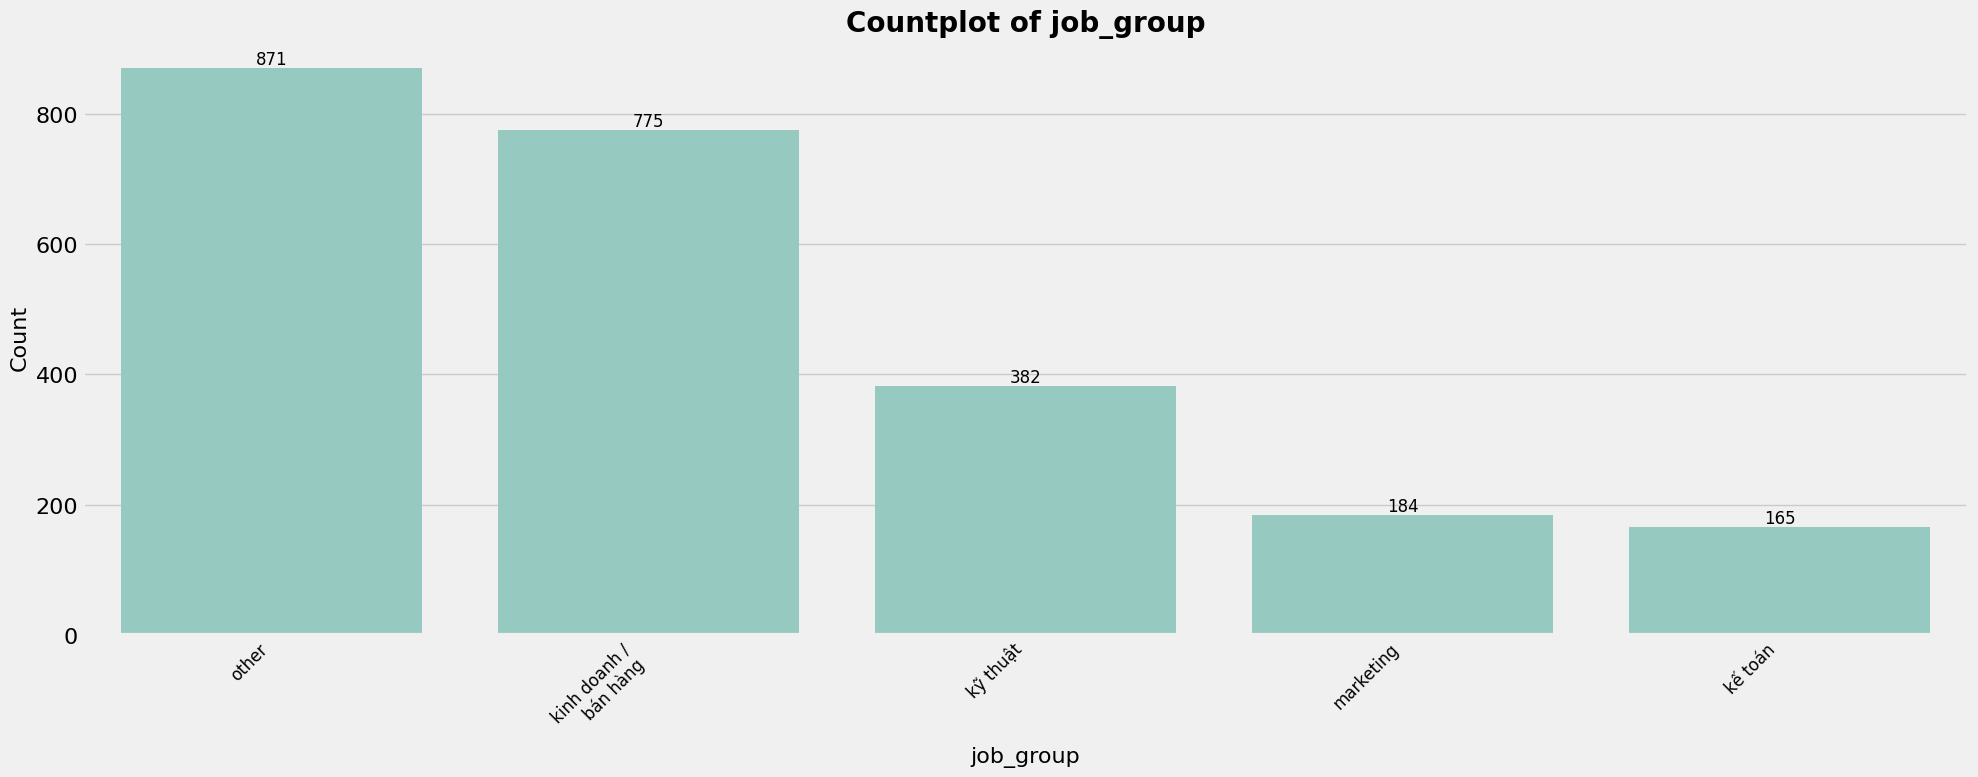

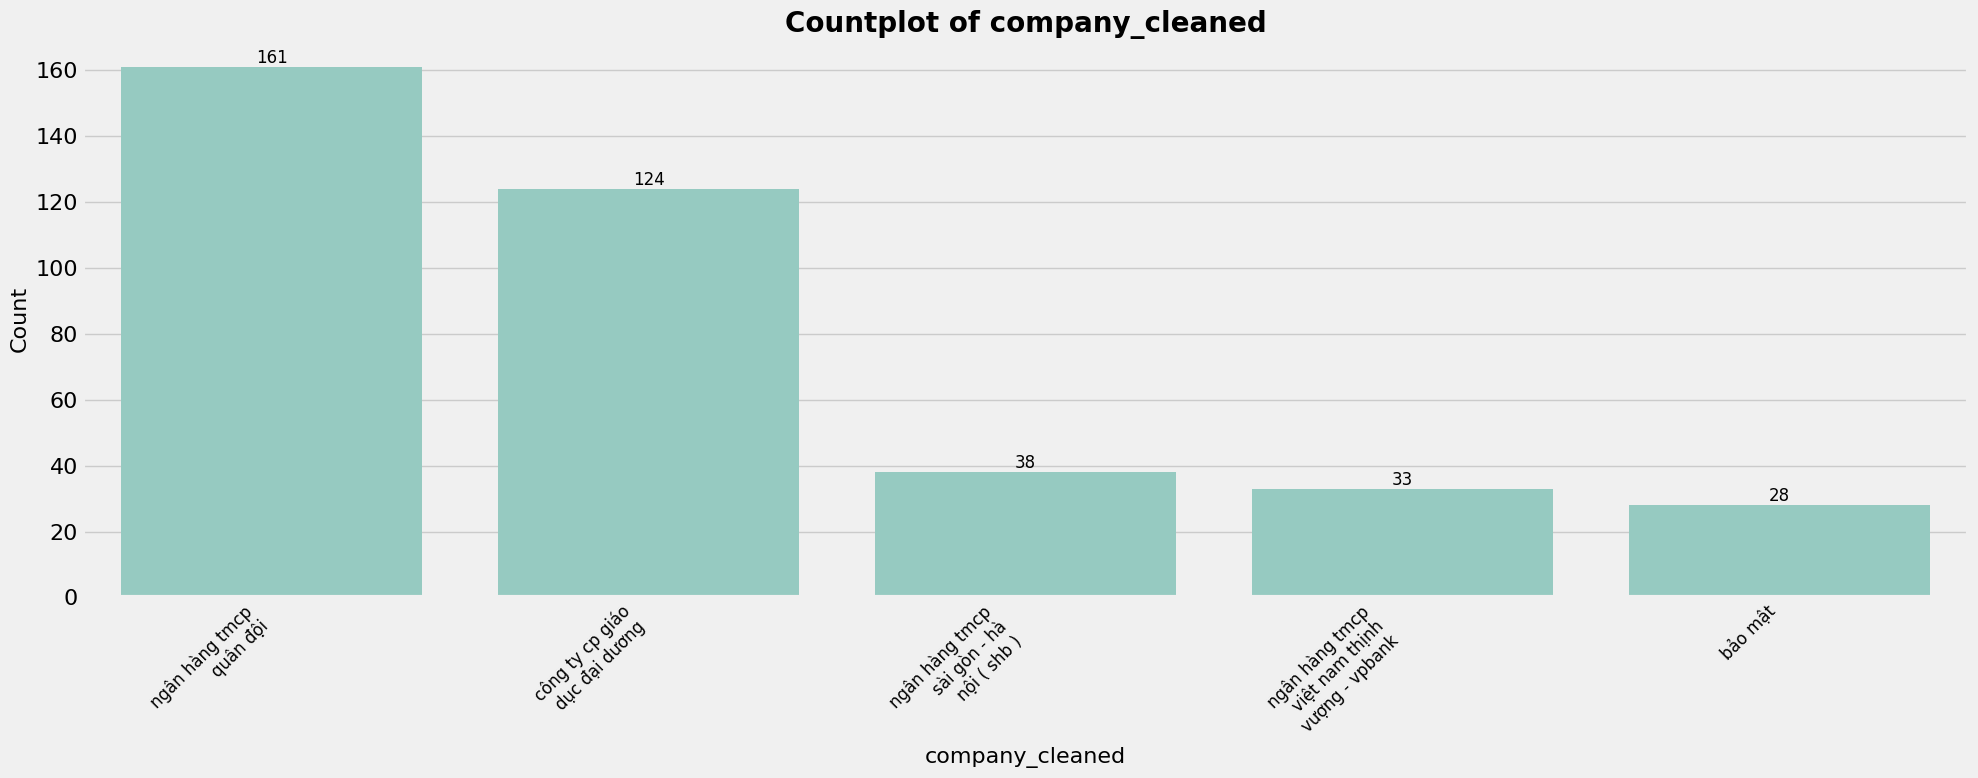

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import textwrap

df_for_viz = df_visualize.select("job_group", "company_cleaned")

# Xử lý null trong Spark
df_for_viz = df_for_viz.fillna({"job_group": "unknown", "company_cleaned": "unknown"})

# Chuyển sang Pandas
pandas_df = df_for_viz.toPandas()

# Thiết lập style và font
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.family': 'Dejavu Sans', 'font.size': 14})

# Thư mục lưu biểu đồ
save_path = "/content/job_company_output"
os.makedirs(save_path, exist_ok=True)

# Hàm vẽ countplot
def plot_countplot(df, column, top_n=5, title=None, save_path=None):
    plt.figure(figsize=(20, 8))
    value_counts = df[column].value_counts()
    if len(value_counts) > top_n:
        top_values = value_counts.head(top_n)
        df_plot = df[df[column].isin(top_values.index)].copy()
        df_plot.loc[~df_plot[column].isin(top_values.index), column] = "khác"
    else:
        df_plot = df
        top_values = value_counts

    ax = sns.countplot(x=column, data=df_plot, order=top_values.index, color="#8DD3C7")
    new_labels = [textwrap.fill(label, width=15) for label in top_values.index]
    ax.set_xticks(range(len(new_labels)))  # Cố định ticks trước
    ax.set_xticklabels(new_labels, fontsize=12)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=12, color='black')

    plt.title(title or f'Countplot of {column}', fontsize=20, fontweight='bold')
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Vẽ countplot cho job_group
plot_countplot(pandas_df, "job_group", top_n=5, save_path=os.path.join(save_path, "job_group_countplot.png"))

# Vẽ countplot cho company_cleaned
plot_countplot(pandas_df, "company_cleaned", top_n=5, save_path=os.path.join(save_path, "company_cleaned_countplot.png"))

###Trực quan hoá Salary

+-----------------+-----------------+----------+----------+----------+--------+-----------+-----------------+
|salary           |salary_cleaned   |min_salary|max_salary|avg_salary|currency|salary_type|is_salary_missing|
+-----------------+-----------------+----------+----------+----------+--------+-----------+-----------------+
|8 Tr - 10 Tr VND |8 tr - 10 tr vnd |8.0       |10.0      |9.0       |VND     |Range      |0                |
|13 Tr - 15 Tr VND|13 tr - 15 tr vnd|13.0      |15.0      |14.0      |VND     |Range      |0                |
|8 Tr - 10 Tr VND |8 tr - 10 tr vnd |8.0       |10.0      |9.0       |VND     |Range      |0                |
|13 Tr - 15 Tr VND|13 tr - 15 tr vnd|13.0      |15.0      |14.0      |VND     |Range      |0                |
|12 Tr - 22 Tr VND|12 tr - 22 tr vnd|12.0      |22.0      |17.0      |VND     |Range      |0                |
|15 Tr - 20 Tr VND|15 tr - 20 tr vnd|15.0      |20.0      |17.5      |VND     |Range      |0                |
|8 Tr - 12

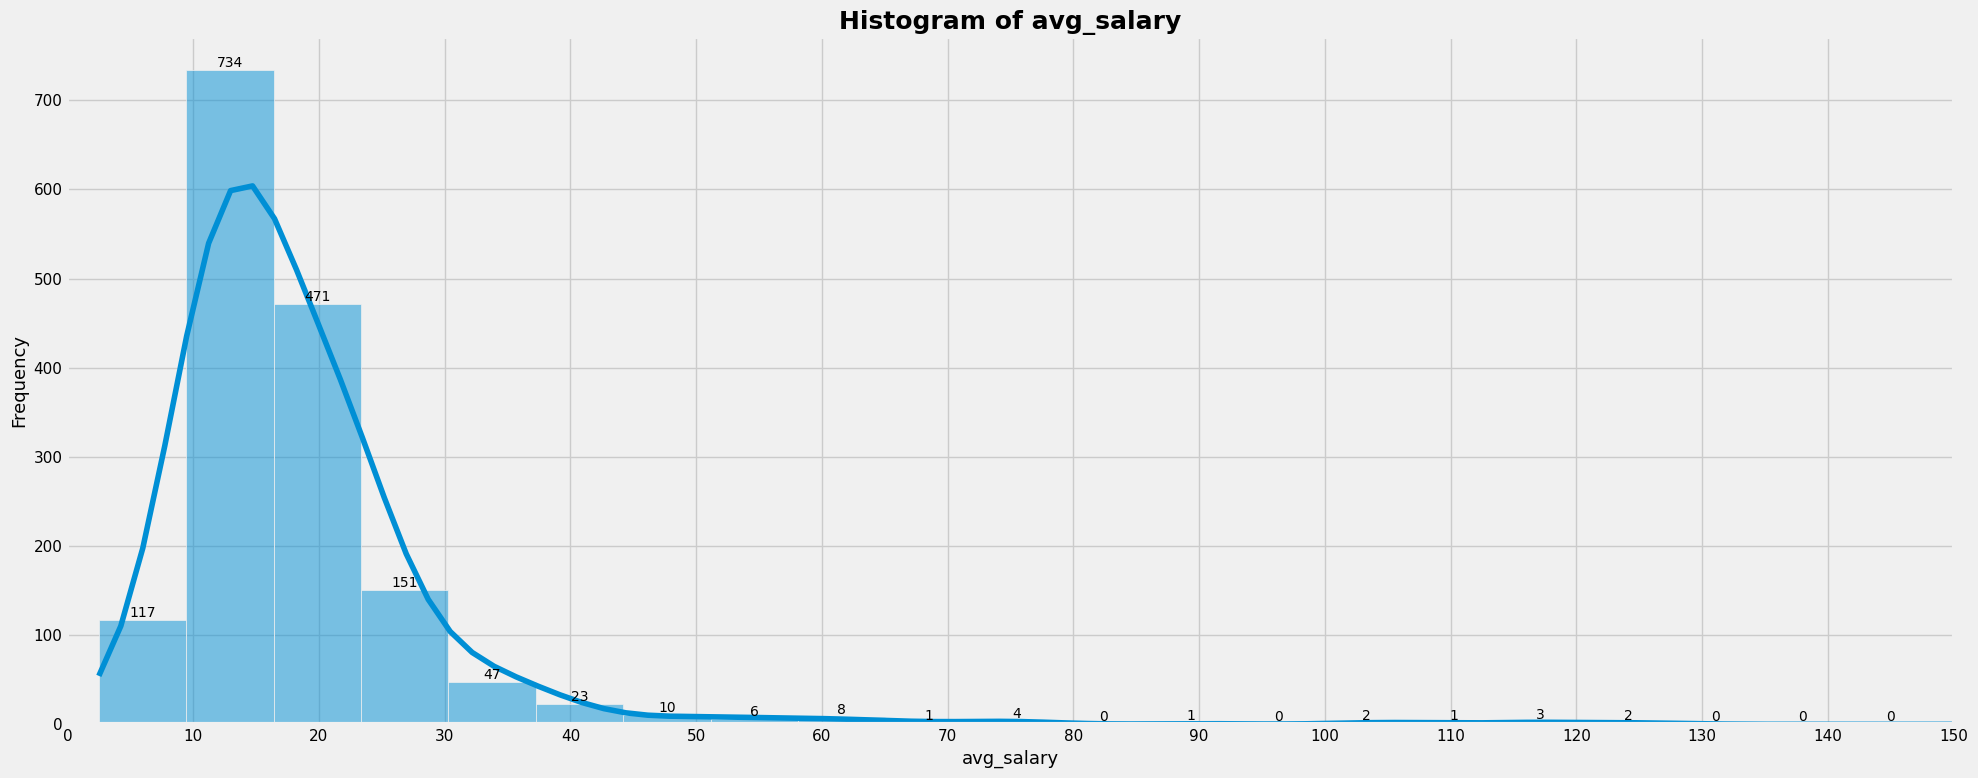

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, when, lit, col, row_number
from pyspark.sql.types import FloatType
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap
import numpy as np

# Sử dụng DataFrame df_preprocessed thay vì đọc từ file Parquet
df_visalary = df_preprocessed  # Giả sử df_preprocessed đã được tạo và có cột salary_cleaned

# Regex patterns
number_pattern_single = r'(\d+(?:[.,]\d+)*)'  # số đơn
number_pattern_range = r'(\d+(?:[.,]\d+)?)[^\d]+(\d+(?:[.,]\d+)?)'  # range

#  Extract currency
df_visalary = df_visalary.withColumn(
    "currency",
    when(col("salary_cleaned").rlike(r'\$|usd'), 'USD')
    .when(col("salary_cleaned").rlike(r'triệu|tr|million|vnd'), 'VND')
    .otherwise('Unknown')
)

# Salary type
df_visalary = df_visalary.withColumn(
    "salary_type",
    when(col("salary_cleaned").rlike(r'-'), 'Range')
    .when(col("salary_cleaned").rlike(r'thỏa thuận|thoả thuận|negotiable|competitive|market'), 'Negotiable')
    .when(col("salary_cleaned").rlike(r'^(từ\b|bắt đầu từ\b|khởi điểm\b|min(imum)?\b|mức thấp nhất\b|starting at\b|start from\b)'), 'From')
    .when(col("salary_cleaned").rlike(r'^(tới\b|tới đa\b|tối đa\b|lên đến\b|cao nhất\b|đến\b|max(imum)?\b|upper limit\b|up to\b)'), 'Up to')
    .otherwise('Single')
)

# Min salary
df_visalary = df_visalary.withColumn(
    "min_salary",
    when(col("salary_type") == 'Range', regexp_extract(col("salary_cleaned"), number_pattern_range, 1))
    .when(col("salary_type") == 'From', regexp_extract(col("salary_cleaned"), number_pattern_single, 1))
    .when(col("salary_type") == 'Up to', lit(None))
    .when(col("salary_type") == 'Single', regexp_extract(col("salary_cleaned"), number_pattern_single, 1))
    .otherwise(None).cast(FloatType())
)

# Max salary
df_visalary = df_visalary.withColumn(
    "max_salary",
    when(col("salary_type") == 'Range', regexp_extract(col("salary_cleaned"), number_pattern_range, 2))
    .when(col("salary_type") == 'Up to', regexp_extract(col("salary_cleaned"), number_pattern_single, 1))
    .when(col("salary_type") == 'From', lit(None))
    .when(col("salary_type") == 'Single', regexp_extract(col("salary_cleaned"), number_pattern_single, 1))
    .otherwise(None).cast(FloatType())
)

# is_salary_missing
df_visalary = df_visalary.withColumn(
    "is_salary_missing",
    when(col("salary_type") == 'Negotiable', lit(1))
    .when(col("min_salary").isNull(), lit(1))
    .otherwise(lit(0))
)

# Thêm chỉ số dòng (row_id) để sắp xếp ngược
window_spec = Window.orderBy(lit(1))  # Giữ nguyên thứ tự ban đầu
df_with_idx = df_visalary.withColumn("row_id", row_number().over(window_spec))  # Sửa df thành df_visalary

# Tính giá trị avg_salary (trung bình cộng của min_salary và max_salary)
df_with_avg_salary = df_with_idx.withColumn(
    "avg_salary",
    (col("min_salary") + col("max_salary")) / 2
)

# Lọc dữ liệu theo logic từ đoạn code thứ nhất
df_cleaned = df_with_avg_salary.filter(
    ~(col("currency").isin("USD", "Unknown")) &  # currency không phải 'USD' hoặc 'Unknown'
    col("min_salary").isNotNull() &  # min_salary không phải null
    col("max_salary").isNotNull() &  # max_salary không phải null
    (col("is_salary_missing") != 1)  # is_salary_missing không phải 1
)

# Hiển thị 20 dòng đầu tiên sau khi lọc
df_cleaned.orderBy(col("row_id").desc()) \
    .select("salary", "salary_cleaned", "min_salary", "max_salary", "avg_salary", "currency", "salary_type", "is_salary_missing") \
    .show(20, truncate=False)

# 1 Lưu kết quả vào một file Parquet mới
output_parquet = '/content/cleaned_job_data_step4_filtered.parquet'
df_cleaned.write.mode('overwrite').parquet(output_parquet)
print(f" Đã lưu kết quả đã lọc tại: {output_parquet}")

# Chuyển sang Pandas để vẽ biểu đồ
df_pd = df_cleaned.select("avg_salary").toPandas()

# Thiết lập style và font
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.family': 'Dejavu Sans'})

# Danh sách các cột để vẽ biểu đồ
variables = ['avg_salary']

# Thư mục lưu biểu đồ
save_path = "/content/histogram_output"
os.makedirs(save_path, exist_ok=True)

# Vẽ biểu đồ
for var in variables:
    if var not in df_pd.columns:
        print(f"Bỏ qua: {var} (không tồn tại trong dữ liệu)")
        continue

    # Tăng chiều ngang để cột rộng hơn và có khoảng cách hơn
    plt.figure(figsize=(20, 8))

    # Biểu đồ histogram cho biến số
    ax = sns.histplot(df_pd[var].dropna(), kde=True, bins=50)

    # Hiển thị giá trị lên đầu các cột trong biểu đồ histogram
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    # Chỉnh sửa các nhãn trục x với khoảng cách 10, 20, 30, ...
    max_value = 150
    plt.title(f'Histogram of {var}', fontsize=18, fontweight='bold')
    plt.xlabel(var, fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.xticks(np.arange(0, max_value + 10, 10), fontsize=11)
    plt.xlim(0, max_value)
    plt.yticks(fontsize=11)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{var}_histogram.png"))
    plt.show()

###Trực Quan Hoá Location

Total 'hà nội' after explode: 1063
Total 'nơi khác' after explode: 74
Total 'hà nội' in Pandas DataFrame: 1063


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-36-121d47460b07>:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


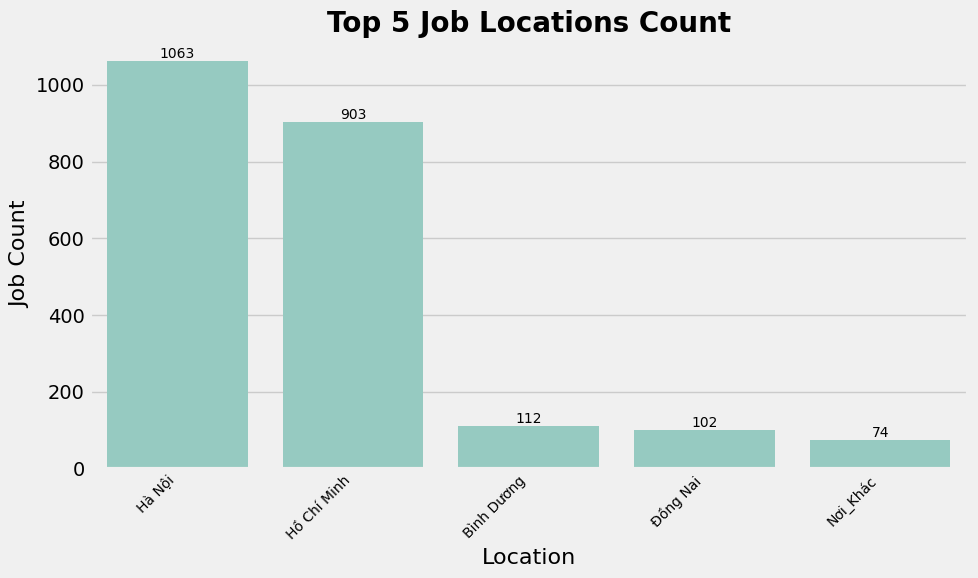

In [ ]:
from pyspark.sql.functions import col, regexp_replace, split, explode, trim, when, lower, regexp_extract, sum as _sum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap
from google.colab import files

# Giả định df_preprocessed đã có sẵn

# 2. Create a copy for visualization
df_visualizetest = df_preprocessed.alias("df_visualizetest").cache()

# 4. Clean thoroughly: handle "nơi khác" without extracting numbers
df_visualizetest = df_visualizetest.withColumn(
    "location_cleaned_processed",
    trim(
        regexp_replace(
            regexp_replace(
                lower(col("location_cleaned")),
                r"\s+", " "  # Normalize spaces
            ),
            r"\s*,\s*", ","  # Normalize commas
        )
    )
).withColumn(
    "location_base",
    regexp_replace(
        col("location_cleaned_processed"),
        r"\d+\s*nơi\s*khác", ",nơi_khác"  # Replace "X nơi khác" with ",nơi_khác"
    )
)

# 5. Split and explode locations
df_exploded = df_visualizetest.withColumn(
    "location_array",
    split(col("location_base"), r",+")
).withColumn(
    "location_exploded_raw",
    explode(col("location_array"))
).withColumn(
    "location_exploded",
    trim(col("location_exploded_raw"))
).filter(col("location_exploded") != "").withColumn(
    "count_adjusted",
    when(col("location_exploded").isNotNull(), 1).otherwise(1)  # Mỗi location đếm là 1
)

# 6. Debugging: Count "hà nội" after explode
hanoi_count_exploded = df_exploded.filter(lower(col("location_exploded")) == "hà nội").agg(_sum("count_adjusted").alias("total_hà_nội")).collect()[0]["total_hà_nội"]
print(f"Total 'hà nội' after explode: {hanoi_count_exploded}")

# Debugging: Count "nơi khác" after explode
nơi_khác_count = df_exploded.filter(col("location_exploded") == "nơi_khác").agg(_sum("count_adjusted").alias("total_nơi_khác")).collect()[0]["total_nơi_khác"]
print(f"Total 'nơi khác' after explode: {nơi_khác_count}")

# 7. Save to CSV for inspection
df_exploded.select("location_exploded", "count_adjusted").coalesce(1).write.csv(
    "location_explode_result.csv",
    header=True,
    mode="overwrite",
    encoding="utf-8"
)

# 8. Read CSV for visualization
part_file = [f for f in os.listdir("location_explode_result.csv") if f.startswith("part-")][0]
df_pd = pd.read_csv(os.path.join("location_explode_result.csv", part_file))

# 9. Debugging: Count "hà nội" in Pandas DataFrame
hanoi_count_pandas = df_pd[df_pd['location_exploded'].str.lower() == "hà nội"]['count_adjusted'].sum()
print(f"Total 'hà nội' in Pandas DataFrame: {hanoi_count_pandas}")

# 10. Export the CSV file for download (Google Colab specific)
files.download(os.path.join("location_explode_result.csv", part_file))

# 11. Visualization setup
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.family': 'DejaVu Sans'})
save_path = "histogram_output"
os.makedirs(save_path, exist_ok=True)

# 12. Generate countplot for top 5 locations
plt.figure(figsize=(10, 6))
location_counts = df_pd.groupby('location_exploded')['count_adjusted'].sum().sort_values(ascending=False).head(5)
ax = sns.barplot(x=location_counts.index, y=location_counts.values, color="#8DD3C7")
ax.set_xticklabels(
    [textwrap.fill(label.title(), width=15) for label in location_counts.index],
    fontsize=10,
    rotation=45,
    ha='right'
)
for i, v in enumerate(location_counts.values):
    ax.annotate(
        f'{int(v)}',
        (i, v),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )
plt.title('Countplot of location_explode', fontsize=20, fontweight='bold')
plt.xlabel('Location', fontsize=16)
plt.ylabel('Job Count', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "top_5_location_countplot.png"), dpi=300, bbox_inches='tight')
plt.show()

##Gắn Nhãn

In [ ]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np


In [ ]:
# Đọc dữ liệu
df = pd.read_csv('features.csv')
print(df.head())


   unique_id location_cleaned  \
0          1           hà nội   
1          2           hà nội   
2          3           hà nội   
3          4           hà nội   
4          5           hà nội   

                                     company_cleaned  \
0                      công ty cổ phần hobi việt nam   
1  công ty trách nhiệm hữu hạn thiết bị công nghi...   
2                 công ty cổ phần tập đoàn ngọc diệp   
3  công ty tnhh một thành viên kinh doanh ô tô th...   
4                     công ty cổ phần đttm hiếu linh   

                                       title_cleaned  \
0  nhân viên kế toán thuế (lương 12,5- 14,5 triệu...   
1  nhân viên kinh doanh/ kế toán tư vấn bán hàng ...   
2  nhân viên xuất nhập khẩu - tiếng trung thành thạo   
3  nhân viên kinh doanh/ sales / tư vấn bán hàng ...   
4        chuyên viên kinh doanh - phụ trách sản phẩm   

                                 description_cleaned  \
0  các công việc chuyên môn, tập hợp hóa đơn,kiểm...   
1  quản lý, chă

In [ ]:
def combined_rule_based_fraud_detection(row):
    title = str(row.get('title_cleaned', '')).lower()
    salary = str(row.get('salary_cleaned', '')).lower()
    company = str(row.get('company_cleaned', '')).lower()
    description = str(row.get('description_cleaned', '')).lower()
    requirements = str(row.get('requirements_cleaned', '')).lower()
    location = str(row.get('location_cleaned', '')).lower()

    score = 0

    # Các cụm từ nghi ngờ chung (đã loại bỏ trùng lặp)
    suspicious_phrases = [
        "thu nhập không giới hạn", "việc nhẹ lương cao", "không cần kinh nghiệm",
        "tuyển gấp", "đào tạo miễn phí", "việc làm thêm", "kiếm tiền nhanh",
        "làm tại nhà", "thu nhập cao", "đa cấp", "chuyển tiền",
        "đầu tư lợi nhuận", "việc dễ", "làm online", "hoa hồng cao",
        "không yêu cầu kinh nghiệm", "việc nhẹ", "không phức tạp",
        "cam kết thu nhập", "lương về tay", "hoa hồng hấp dẫn", "không cần bằng cấp",
        "làm ngay trong ngày", "cơ hội làm giàu", "cơ hội đầu tư", "tiền về tài khoản",
        "tự do tài chính", "chỉ cần điện thoại", "việc đơn giản", "uy tín hàng đầu",
        "việc lương thưởng cao"
    ]
    if any(phrase in requirements or phrase in description for phrase in suspicious_phrases):
        score += 1

    # Yêu cầu đóng phí
    if any(fee in description for fee in ["đóng phí", "đặt cọc", "phí tham gia", "phí đồng phục"]):
        score += 1

    # Email không chuyên nghiệp
    if "@" in description and any(domain in title for domain in ["@gmail", "@yahoo", "@outlook", "@hotmail"]):
        score += 1
    if "@gmail.com" in description or "@yahoo.com" in description:
        score += 1  # chỉ cộng thêm nếu xuất hiện rõ ràng

    # Thiếu thông tin
    if company.strip() == "" or company in ["không rõ", "n/a", "none", "unknown"]:
        score += 1
    if location.strip() == "" or location in ["không rõ", "n/a", "none", "unknown"]:
        score += 1
    if requirements.strip() == "" or requirements in ["không rõ", "n/a", "none", "unknown"]:
        score += 1

     # Mức lương bất thường hoặc mơ hồ
    if any(term in salary for term in ["không giới hạn", "thỏa thuận cao", "thu nhập cao", "vô hạn"]):
        score += 1

    # Tiêu đề có từ khóa lôi kéo
    if any(term in title for term in ["việc nhẹ", "lương cao", "online", "tuyển gấp", "làm ngay", "tuyển dụng gấp"]):
        score += 1

    # Liên hệ đáng ngờ
    if any(term in description for term in ["telegram", "ib ngay", "inbox", "liên hệ gấp"]):
        score += 1

    #Quá nhiều dấu chấm than, ký tự đặc biệt (mồi chài)
    if description.count("!") > 3 or description.count("$") > 2:
        score += 1

    # Thêm điểm nếu các cờ logic được kích hoạt
    if row.get('is_unrealistic_salary') == 1:
        score += 1
    if row.get('flag_quality_issues') == 1:
        score += 1
    if row.get('is_salary_missing') == 1:
        score += 1

    return 1 if score >= 2 else 0
# Áp dụng phương pháp rule-based
df['is_fraud_rule'] = df.apply(combined_rule_based_fraud_detection, axis=1)

# Phân loại cuối cùng chính là kết quả rule-based
df['final_fraud_pred'] = df['is_fraud_rule']

# Hiển thị kết quả
print(df[['title_cleaned', 'is_fraud_rule', 'final_fraud_pred']].head())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   unique_id             2715 non-null   int64 
 1   location_cleaned      2715 non-null   object
 2   company_cleaned       2715 non-null   object
 3   title_cleaned         2715 non-null   object
 4   description_cleaned   2715 non-null   object
 5   requirements_cleaned  2715 non-null   object
 6   benefits_cleaned      2715 non-null   object
 7   salary_cleaned        2715 non-null   object
 8   is_fraud_rule         2715 non-null   int64 
 9   final_fraud_pred      2715 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 212.2+ KB


In [ ]:
# Xuất kết quả ra file
output_cols = [
    'title_cleaned',
    'salary_cleaned',
    'description_cleaned',
    'requirements_cleaned',
    'final_fraud_pred'
]
df_output = df[output_cols]
df_output.to_excel('fraud_detection_results.xlsx', index=False)
print("Kết quả đã được lưu vào file 'fraud_detection_results.xlsx'")

Kết quả đã được lưu vào file 'fraud_detection_results.xlsx'


In [ ]:
df=df_output

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title_cleaned         2715 non-null   object
 1   salary_cleaned        2715 non-null   object
 2   description_cleaned   2715 non-null   object
 3   requirements_cleaned  2715 non-null   object
 4   final_fraud_pred      2715 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 106.2+ KB


In [ ]:
pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer

In [ ]:
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
phobert_model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
df['combined_text'] = (df['title_cleaned'] + " " + df['description_cleaned'] + " " + df['requirements_cleaned'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title_cleaned         2715 non-null   object
 1   salary_cleaned        2715 non-null   object
 2   description_cleaned   2715 non-null   object
 3   requirements_cleaned  2715 non-null   object
 4   final_fraud_pred      2715 non-null   int64 
 5   combined_text         2715 non-null   object
dtypes: int64(1), object(5)
memory usage: 127.4+ KB


In [ ]:
#Def Trích xuất vector đặc trưng từ PhoBERT
def extract_phobert_features(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = phobert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

In [ ]:
# Trích xuất đặc trưng cho mỗi mẫu
features = []
for text in df['combined_text']:
    features.append(extract_phobert_features(text))

# Tạo DataFrame từ các đặc trưng
feature_columns = [f'phobert_feature_{i}' for i in range(768)]
df_features = pd.DataFrame(features, columns=feature_columns)

# Ghép vào DataFrame gốc
df = pd.concat([df, df_features], axis=1)


In [ ]:
df.head()

,title_cleaned,salary_cleaned,description_cleaned,requirements_cleaned,final_fraud_pred,combined_text,phobert_feature_0,phobert_feature_1,phobert_feature_2,phobert_feature_3,...,phobert_feature_758,phobert_feature_759,phobert_feature_760,phobert_feature_761,phobert_feature_762,phobert_feature_763,phobert_feature_764,phobert_feature_765,phobert_feature_766,phobert_feature_767
0,"nhân viên kế toán thuế (lương 12,5- 14,5 triệu...",12.5 - 14.5 triệu,"các công việc chuyên môn, tập hợp hóa đơn,kiểm...",trình độ học vấn: tốt nghiệp đại học chuyên ng...,0,"nhân viên kế toán thuế (lương 12,5- 14,5 triệu...",-0.211882,0.531524,-0.904433,-0.382053,...,0.125627,-0.055001,0.144110,0.112766,-0.146211,0.163406,0.377539,0.149945,-0.602839,-0.111988
1,nhân viên kinh doanh/ kế toán tư vấn bán hàng ...,10 - 30 triệu,"quản lý, chăm sóc khách hàng của công ty, tìm ...","nhân viên nam, nữ - tốt nghiệp cao đẳng trở lê...",0,nhân viên kinh doanh/ kế toán tư vấn bán hàng ...,-0.070142,0.490063,-1.220551,-0.464515,...,0.118347,-0.402707,0.149485,0.261760,-0.244254,0.083962,0.206232,-0.196643,-0.696167,-0.258733
2,nhân viên xuất nhập khẩu - tiếng trung thành thạo,thoả thuận,phụ trách công việc mua bán - xuất nhập khẩu h...,"tiếng trung hoặc tiếng anh thành thạo, có ít n...",0,nhân viên xuất nhập khẩu - tiếng trung thành t...,-0.046263,0.869155,-1.105002,-0.620651,...,0.219183,-0.556719,0.212752,0.001158,-0.456253,-0.202927,0.459219,-0.065241,-0.670529,-0.421638
3,nhân viên kinh doanh/ sales / tư vấn bán hàng ...,10 - 40 triệu,nhận và thực hiện chỉ tiêu bán hàng của cá nhâ...,"giới tính: nam, nữ, độ tuổi: từ 22 đến dưới 35...",0,nhân viên kinh doanh/ sales / tư vấn bán hàng ...,0.062267,0.457793,-1.050088,-0.601277,...,0.355176,-0.411720,0.036759,0.278785,-0.461368,-0.067015,0.326400,0.079339,-0.581347,-0.530857
4,chuyên viên kinh doanh - phụ trách sản phẩm,thoả thuận,lĩnh vực sản phẩm: vật tư chuyên sâu ngành y t...,"yêu cầu ứng viên tốt nghiệp cao đẳng trở lên, ...",0,chuyên viên kinh doanh - phụ trách sản phẩm lĩ...,0.021290,0.512794,-1.020054,-0.581133,...,0.150753,-0.208924,0.119237,0.173110,-0.297299,-0.032676,0.417267,0.034189,-0.565024,-0.298742


In [ ]:
pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split


# Tách features và target
X = df.drop(['title_cleaned', 'salary_cleaned', 'description_cleaned', 'requirements_cleaned', 'combined_text', 'final_fraud_pred'], axis=1)
y = df['final_fraud_pred']

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Kiểm tra phân phối của biến mục tiêu trong tập dữ liệu train
print("Phân phối trước khi áp dụng SMOTE:")
print(y_train.value_counts())

# Áp dụng SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tạo DataFrame mới từ dữ liệu đã được cân bằng
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['final_fraud_pred'] = y_resampled

# Kiểm tra phân phối sau khi áp dụng SMOTE
print("\nPhân phối sau khi áp dụng SMOTE:")
print(df_resampled['final_fraud_pred'].value_counts())

# Lưu DataFrame đã được cân bằng
df_resampled.to_csv('balanced_dataset.csv', index=False)
print("\nDữ liệu đã được cân bằng và lưu vào file 'balanced_dataset.csv'")

Phân phối trước khi áp dụng SMOTE:
final_fraud_pred
0    2123
1      49
Name: count, dtype: int64


<ipython-input-58-fd00ca8e46a0>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['final_fraud_pred'] = y_resampled



Phân phối sau khi áp dụng SMOTE:
final_fraud_pred
0    2123
1    2123
Name: count, dtype: int64

Dữ liệu đã được cân bằng và lưu vào file 'balanced_dataset.csv'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


# KNN
knn = KNeighborsClassifier()
knn.fit(X_resampled, y_resampled)
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_resampled, y_resampled)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

# SVM
svm = SVC(random_state=42)
svm.fit(X_resampled, y_resampled)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

KNN Accuracy: 0.8232044198895028
KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90       531
           1       0.10      0.92      0.19        12

    accuracy                           0.82       543
   macro avg       0.55      0.87      0.54       543
weighted avg       0.98      0.82      0.89       543

Decision Tree Accuracy: 0.9429097605893186
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       531
           1       0.15      0.33      0.21        12

    accuracy                           0.94       543
   macro avg       0.57      0.65      0.59       543
weighted avg       0.97      0.94      0.95       543

SVM Accuracy: 0.990791896869245
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       531
           1       0.77      0.83  

In [ ]:
from sklearn.metrics import confusion_matrix

# Ma trận nhầm lẫn cho KNN
confusion_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN:")
print(confusion_knn)

# Ma trận nhầm lẫn cho Decision Tree
confusion_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix for Decision Tree:")
print(confusion_dt)

# Ma trận nhầm lẫn cho SVM
confusion_svm = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion Matrix for SVM:")
print(confusion_svm)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Tính toán đường cong ROC và AUC cho từng mô hình
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Đường chéo
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Cấu hình đồ thị
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Ma trận nhầm lẫn cho KNN
confusion_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN:")
print(confusion_knn)

# Ma trận nhầm lẫn cho Decision Tree
confusion_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix for Decision Tree:")
print(confusion_dt)

# Ma trận nhầm lẫn cho SVM
confusion_svm = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion Matrix for SVM:")
print(confusion_svm)

Confusion Matrix for KNN:
[[495  45]
 [  1   2]]

Confusion Matrix for Decision Tree:
[[538   2]
 [  3   0]]

Confusion Matrix for SVM:
[[540   0]
 [  3   0]]


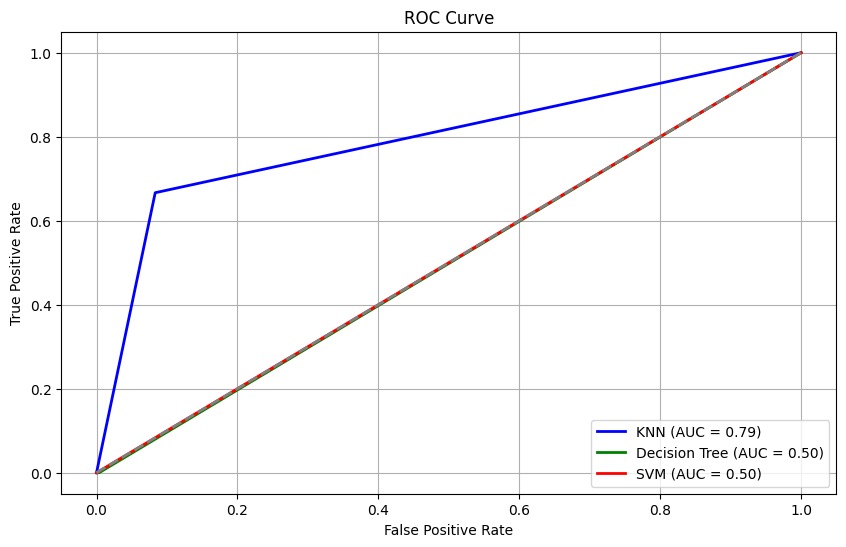

In [ ]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Tính toán đường cong ROC và AUC cho từng mô hình
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Đường chéo
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Cấu hình đồ thị
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()